# Setup

In [1]:
import os
import scipy
import random
import datetime
import importlib
import numpy as np
import scipy.sparse.linalg
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Callable, List, Union
from scipy.sparse.linalg import gmres, LinearOperator
from numpy.linalg import cond
from matrixlib.core import MatrixData, ValueProperties, BlockProperties
from matrixlib.plot import plot_matrices_and_metadata
#import CNN
import CNN.models
import CNN.training
import CNN.evaluation

# Check wd
current_base_path = os.getcwd()
print(f"Path to current working directory: {current_base_path}")
!whoami

2024-06-22 10:30:20.181749: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-22 10:30:22.750897: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Path to current working directory: /home/moonchild/PycharmProjects/opencampus-preconditioner-ai-project
moonchild


In [ ]:
# !pip install tensorflow-gpu==2.3.0

In [ ]:
# !pip install tensorflow[and-cuda]

In [ ]:
# %%capture
# !pip install numpy==1.23.1 Pillow==9.2.0 importlib-metadata==4.11.3 matplotlib==3.5.2 scikit-learn==1.1.1 tensorboard==2.9.1 jupyter==1.0.0 ipykernel==6.9.1 seaborn==0.13.2

In [ ]:
# import sys
# import os
# 
# # Add the project directory to the Python path
# sys.path.append('/home/azureuser/projects/opencampus-preconditioner-ai-project')
# 
# # Change the working directory to the project directory
# os.chdir('/home/azureuser/projects/opencampus-preconditioner-ai-project')
# print(os.getcwd())  # Verify the change

In [ ]:
tf.config.list_physical_devices('GPU') 

# Generate Synthetic Data
Generate a set of `n` square symmetrical and positive semi matrices of dimensions `MATRIX_DIM` to RAM.

## Define Constants
The following constants are used throughout the rest of the notebook.

In [2]:
MATRIX_DIM = 64
NUMBER_OF_MATRICES = 1000
DIAGONAL_BAND_RADIUS = 10
RNG_SEED = 42
VALUE_COLORBAR = 'rocket'
BLOCK_COLORBAR = 'flare'

initialized        data vectors of size   1000 x  64 x  64 =   4096000 with a memory usage of  15.625 MiB
initialized  data start vectors of size   1000 x  64       =     64000 with a memory usage of   0.061 MiB
initialized noise start vectors of size   1000 x  64       =     64000 with a memory usage of   0.061 MiB
initialized        band vectors of size   1000 x  64 x  10 =    640000 with a memory usage of   5.127 MiB
--------------------------------------------------------------------------------
instantiation rng generators...
generating matrices...
matrix at [312] is invalid (det = 0.0029243261087685823) -> re-generating.
invalid matrices: 1
determinant abs-value range: [0.010296251624822617, 5508474.0]


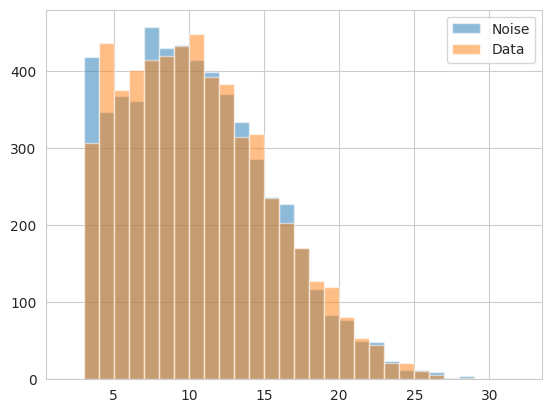

duration: 6.83 seconds


In [3]:
# Generate matrices
bgr_noise_value_props = ValueProperties(density_range=(0.3, 0.5), value_range=(0.0, 0.5))
noise_blk_value_props = ValueProperties(density_range=(0.3, 0.5), value_range=(0.3, 1.0))
noise_blk_block_props = BlockProperties(size_range=(3, 32), size_average=10, size_std_dev=0.66, gap_chance=0.5)
tdata_blk_value_props = ValueProperties(density_range=(0.5, 0.7), value_range=(0.3, 1.0))
tdata_blk_block_props = BlockProperties(size_range=(2, 32), size_average=10, size_std_dev=0.66, gap_chance=0.5)

test_data = MatrixData(
        dimension=MATRIX_DIM,
        band_radius=DIAGONAL_BAND_RADIUS,
        sample_size=NUMBER_OF_MATRICES,
        background_noise_value_properties=bgr_noise_value_props,
        block_noise_value_properties=noise_blk_value_props,
        block_noise_block_properties=noise_blk_block_props,
        block_data_value_properties=tdata_blk_value_props,
        block_data_block_properties=tdata_blk_block_props,
        seed=42,
        determinant_cutoff=0.01,
        print_debug=True
    )

In [5]:
test_data.tdata_blk_starts[0]
test_data.bands.shape

(1000, 21, 64)

In [9]:
bands = test_data.bands.reshape(NUMBER_OF_MATRICES, (DIAGONAL_BAND_RADIUS* 2 + 1), MATRIX_DIM, 1)
bands = np.nan_to_num(bands) # replace NaNs with 0s
labels = test_data.block_data_start_labels
print(bands.shape, labels.shape)

# Create dataset from matrices and labels
dataset = tf.data.Dataset.from_tensor_slices((bands, labels))

# Split the dataset
train_size = int(0.8 * NUMBER_OF_MATRICES)
val_size = int(0.1 * NUMBER_OF_MATRICES)
test_size = NUMBER_OF_MATRICES - train_size - val_size

train_dataset = dataset.take(train_size).shuffle(buffer_size=10)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")


AttributeError: 'MatrixData' object has no attribute 'block_data_start_labels'

In [ ]:
# Verfiy Shape
print(train_dataset)
print(val_dataset)
print(test_dataset)

# for element in val_dataset:
#    print(element)

# Training
run tensorboard --logdir logs to launch tensorboard

In [ ]:
importlib.reload(CNN.training)
importlib.reload(CNN.models)

# Define parameters
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
num_epochs = 10

# Create log dir
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
print("Files in log directory:", os.listdir(log_dir))

def set_seeds(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seeds()

# Compile Model
model = CNN.models.Baseline(input_shape=((DIAGONAL_BAND_RADIUS * 2 + 1), MATRIX_DIM, 1))
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [ ]:
# Start Training Loop
trained_model, train_losses, val_losses = CNN.training.train_model(
    model=model,
    train_dataset=train_dataset.batch(1),  # Adjust when connected to vm
    val_dataset=val_dataset.batch(1),
    loss_fn=loss_fn,
    optimizer=optimizer,
    num_epochs=num_epochs,
    log_dir=log_dir
)

In [ ]:
model.summary

In [ ]:
# Plot losses
def plot_losses(train_losses, val_losses):
    """
    Plots the training and validation losses.

    Args:
        train_losses (list of float): List of training losses per epoch.
        val_losses (list of float): List of validation losses per epoch.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses, val_losses)

# Evaluation

In [ ]:
# Evaluate the model on the test set
evaluation_results = CNN.evaluation.evaluate_model(
    model=trained_model,
    test_dataset=test_dataset.batch(1),
    loss_fn=loss_fn
)

In [ ]:
import h5py
# Restore weights from best run
new_model = CNN.models.Baseline(input_shape=((DIAGONAL_BAND_RADIUS * 2 + 1), MATRIX_DIM, 1))
new_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# best_checkpoint_file = os.path.join(log_dir, "baseline_final.weights.h5")  
new_model.load_weights("/home/moonchild/PycharmProjects/opencampus-preconditioner-ai-project/logs/fit/20240620-160632/model.10-0.3015.weights.h5")

# Log model weights after loading
print("Model weights after loading:")
print(new_model.get_weights())

# Evaluate the restored model
new_results = CNN.evaluation.evaluate_model(
    model=new_model,
    test_dataset=test_dataset.batch(1),
    loss_fn=loss_fn
)

# Prediction

In [ ]:
# Extract test matrices and labels from dataset
test_bands = bands[train_size + val_size:]
test_labels = labels[train_size + val_size:]

# Make Predictions
test_predictions = trained_model.predict(test_dataset.batch(2))

# Convert to Binary
threshold = 0.5
binary_predictions = (test_predictions >= threshold).astype(int)

# Calculate Metrics
overall_accuracy = (binary_predictions == test_labels).mean()
print("Overall Accuracy:")
print(overall_accuracy)

In [ ]:
test_matrices = test_data.matrices[train_size + val_size:]
print(test_matrices.shape)
print(test_bands.shape)
print(binary_predictions.shape)

for i in range(min(5, test_matrices.shape[0])):
    print(f"Condition number of matrix {i}: {np.linalg.cond(A[i])}")


# Create Preconditioner from predicted block starts
### 1. Form Blocks from Predictions
### 2. Invert Blocks (ensure non-singularity)
### 3. Create Block Diagonal Matrix



In [ ]:
# def ensure_nonsingularity(A: np.ndarray, band_width: int = 10) -> np.ndarray:
#     """
#     Modifies the input matrices to ensure non-singularity by replacing all nonzero entries 
#     with values in the range (-1, 0) and setting all diagonal band values to 1.0.
# 
#     Args:
#         A: NumPy array of shape (n, m, m) representing n square matrices of size m x m.
#         band_width: Width of the diagonal band to set to 1.0 (default is 1, which is just the main diagonal)
# 
#     Returns:
#         Modified NumPy array.
#     """
#     A_mod = np.copy(A)
#     n, m, _ = A.shape
#     
#     for k in range(n):
#         # Replace nonzero off-diagonal elements with random values in (-1, 0)
#         mask = (A_mod[k] != 0) & ~np.eye(m, dtype=bool)
#         A_mod[k][mask] = np.random.uniform(-1, 0, size=np.sum(mask))
#         
#         # Set diagonal band to 1.0
#         for i in range(m):
#             for j in range(max(0, i-band_width+1), min(m, i+band_width)):
#                 A_mod[k, i, j] = 1.0
# 
#     return A_mod

In [ ]:
def block_jacobi_preconditioner_from_predictions(A, binary_predictions):
    n, m, _ = A.shape
    prec = np.zeros_like(A)

    for k in range(n):
        block_starts = np.where(binary_predictions[k] == 1)[0]
        block_starts = np.append(block_starts, m)

        for i in range(len(block_starts) - 1):
            start = block_starts[i]
            end = block_starts[i + 1]            
            # prec[k, start:end, start:end] = A[k, start:end, start:end]
            block = A[k, start:end, start:end]
            prec[k, start:end, start:end] = scipy.linalg.inv(block)  # Invert each block

    return prec


def solve_with_gmres_monitored(A: np.ndarray, b: np.ndarray, M: np.ndarray = None, maxiter: int = 1000, rtol: float = 1e-3) -> tuple[np.ndarray, np.ndarray, np.ndarray, list]:
    n, m, _ = A.shape
    x_solutions = np.zeros_like(b)
    info_array = np.zeros(n, dtype=int)
    iteration_counts = np.zeros(n, dtype=int)
    all_residuals = []

    for k in range(n):
        iteration_count = [0]
        residuals = []

        def callback(rk, xk=None, sk=None):
            iteration_count[0] += 1
            residuals.append(rk)            

        if M is not None:
            M_op = LinearOperator(matvec=lambda x: M[k] @ x, shape=(m, m))   # Apply preconditioner by multiplication
            x, info = gmres(A[k], b[k], x0=np.zeros_like(b[k]), M=M_op, maxiter=maxiter, rtol=rtol, callback=callback, callback_type='pr_norm')
        else:
            x, info = gmres(A[k], b[k], x0=np.zeros_like(b[k]), maxiter=maxiter, rtol=rtol, callback=callback, callback_type='pr_norm')

        x_solutions[k] = x
        info_array[k] = info
        iteration_counts[k] = iteration_count[0]
        all_residuals.append(residuals)
        
    return x_solutions, info_array, iteration_counts, all_residuals

# Run GMRES Solver with and without Precodnitioner

In [ ]:
A = test_matrices
precs = block_jacobi_preconditioner_from_predictions(A, binary_predictions)
b = np.ones((A.shape[0], A.shape[1]))
# Solve without preconditioner
x_no_prec, info_no_prec, iters_no_prec, residuals_no_prec = solve_with_gmres_monitored(A, b)

# Solve with block Jacobi preconditioner
x_prec, info_prec, iters_prec, residuals_prec = solve_with_gmres_monitored(A, b, M=precs)

# Print summary statistics
print("Without preconditioner:")
print(f"  Converged: {np.sum(info_no_prec == 0)} out of {len(info_no_prec)}")
print(f"  Average iterations: {np.mean(iters_no_prec):.2f}")

print("\nWith Block Jacobi preconditioner:")
print(f"  Converged: {np.sum(info_prec == 0)} out of {len(info_prec)}")
print(f"  Average iterations: {np.mean(iters_prec):.2f}")

# Compare final residuals
final_residuals_no_prec = [res[-1] if res else np.inf for res in residuals_no_prec]
final_residuals_prec = [res[-1] if res else np.inf for res in residuals_prec]

print("\nFinal residual comparison:")
print(f"  Without preconditioner: min={np.min(final_residuals_no_prec):.2e}, max={np.max(final_residuals_no_prec):.2e}, mean={np.mean(final_residuals_no_prec):.2e}")
print(f"  With preconditioner: min={np.min(final_residuals_prec):.2e}, max={np.max(final_residuals_prec):.2e}, mean={np.mean(final_residuals_prec):.2e}")

# Calculate and print the relative residuals
rel_residuals_no_prec = [np.linalg.norm(b[i] - A[i] @ x_no_prec[i]) / np.linalg.norm(b[i]) for i in range(A.shape[0])]
rel_residuals_prec = [np.linalg.norm(b[i] - A[i] @ x_prec[i]) / np.linalg.norm(b[i]) for i in range(A.shape[0])]

print("\nRelative residual:")
print(f"  Without preconditioner: min={np.min(rel_residuals_no_prec):.2e}, max={np.max(rel_residuals_no_prec):.2e}, mean={np.mean(rel_residuals_no_prec):.2e}")
print(f"  With preconditioner: min={np.min(rel_residuals_prec):.2e}, max={np.max(rel_residuals_prec):.2e}, mean={np.mean(rel_residuals_prec):.2e}")

In [ ]:
# Plot convergence for a few matrices
num_plots = min(2, A.shape[0])
fig, axes = plt.subplots(num_plots, 1, figsize=(6, 4*num_plots), sharex=True)
fig.suptitle('GMRES Convergence')

for i in range(num_plots):
    ax = axes[i] if num_plots > 1 else axes
    ax.semilogy(residuals_no_prec[i], label='No preconditioner')
    ax.semilogy(residuals_prec[i], label='Block Jacobi preconditioner')
    ax.set_ylabel(f'Matrix {i+1}\nResidual norm')
    ax.legend()

axes[-1].set_xlabel('Iteration')
plt.tight_layout()
plt.show()

In [ ]:
# Function to plot matrices
def plot_matrices(matrices: List[np.ndarray], titles: List[str], colorbar: str = VALUE_COLORBAR) -> None:
    num_matrices = len(matrices)
    fig, axes = plt.subplots(1, num_matrices, figsize=(5 * num_matrices, 5))

    for i, (matrix, title) in enumerate(zip(matrices, titles)):
        ax = axes[i] if num_matrices > 1 else axes
        sns.heatmap(matrix, cmap=colorbar, ax=ax, cbar=True)
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()
    
# Plot matrices
plot_matrices([test_matrices[0], precs[0]], ['Original Matrix', 'Preconditioner'], colorbar=VALUE_COLORBAR)

In [ ]:
# Check condition number
from numpy.linalg import cond

print(f"Condition number original: {cond(test_matrices[0])}")
print(f"Frobenius norm of difference between preconditioner and inverse: {np.linalg.norm(precs[0] - np.linalg.inv(A[0]))}")
#residual = np.linalg.norm(b_example - A_example @ x_prec)
#print(f"Residual after preconditioned GMRES: {residual}")